In [74]:
from mcculw import ul
from mcculw.enums import InterfaceType
from mcculw.device_info import DaqDeviceInfo
from mcculw.enums import ULRange,AnalogInputMode
import time
import numpy as np
from matplotlib import pyplot as plt
import json
import matplotlib.cm as cm
import pandas as pd

In [75]:
colors = ['tab:red', 'tab:orange', 'tab:olive', 'tab:green', 'tab:cyan', 'tab:blue', 'tab:purple', 'tab:pink', 'tab:brown']

In [76]:
AI_name = 'USB-1608G'
AO_name = 'USB-3105'

In [77]:
ul.ignore_instacal()
devices = ul.get_daq_device_inventory(InterfaceType.ANY)

if not devices:
        raise Exception('Error: No DAQ devices found')

for d in devices:
    if d.product_name == AI_name:
        AI = d
    elif d.product_name == AO_name:
        AO = d

In [78]:
in_num = 0
ul.create_daq_device(in_num, AI)

out_num=1
ul.create_daq_device(out_num, AO)

In [79]:
#set ranges

ai_range = ULRange.BIP10VOLTS 
ai_range_Vr = ULRange.BIP1VOLTS 
ul.a_input_mode(in_num, AnalogInputMode.SINGLE_ENDED) # SE mode

daq_dev_info = DaqDeviceInfo(out_num)
ao_range = daq_dev_info.get_ao_info().supported_ranges[0]

In [80]:
out_V0_ch = 11
out_LED_ch = 13

out_Vg1_ch = 5
out_Vg2_ch = 7
out_Vg3_ch = 9
out_Vg4_ch = 0
out_Vg5_ch = 2
out_Vg6_ch = 4
out_Vg7_ch = 6
out_Vg8_ch = 8
out_Vg9_ch = 10
in_V0_ch = 7
in_V1_ch = 0
in_V2_ch = 1
in_V3_ch = 9
in_V4_ch = 2
in_V5_ch = 10
in_V6_ch = 3
in_V7_ch = 11
in_V8_ch = 14
in_V9_ch = 6
in_Vr_ch = 15

R0 = 100 #shunt resistance
GND = 0 #V
LED_supply = 3 #V
gain = 3.

# Vg1 = 2.48
# Vg2 = 2.53
# Vg3 = 2.6
# Vg4 = 2.62
# Vg5 = 2.61
# Vg6 = 2.42
# Vg7 = 2.33
# Vg8 = 2.43
# Vg9 = 2.445

Vg1 = 2.4
Vg2 = 2.4
Vg3 = 2.4
Vg4 = 2.4
Vg5 = 2.4
Vg6 = 2.4
Vg7 = 3.65
Vg8 = 2.4
Vg9 = 2.4

edgecomms = pd.DataFrame({'edge': pd.Series([1,2,3,4,5,6,7,8,9], dtype='int'), 
                          'out_Vg': pd.Series([out_Vg1_ch, out_Vg2_ch, out_Vg3_ch, out_Vg4_ch, out_Vg5_ch, out_Vg6_ch, out_Vg7_ch, out_Vg8_ch, out_Vg9_ch], dtype='int'), 
                          'in_dV':pd.Series([in_V1_ch, in_V2_ch, in_V3_ch, in_V4_ch, in_V5_ch, in_V6_ch, in_V7_ch, in_V8_ch, in_V9_ch], dtype='int'), 
                         'Vgg': pd.Series([Vg1, Vg2, Vg3, Vg4, Vg5, Vg6, Vg7, Vg8, Vg9], dtype='float')})
print(edgecomms)
for e in edgecomms.itertuples():
    ul.v_out(out_num, e.out_Vg, ao_range, e.Vgg)
ul.v_out(out_num, out_V0_ch, ao_range, 0)
ul.v_out(out_num, out_LED_ch, ao_range, LED_supply)

   edge  out_Vg  in_dV   Vgg
0     1       5      0  2.40
1     2       7      1  2.40
2     3       9      9  2.40
3     4       0      2  2.40
4     5       2     10  2.40
5     6       4      3  2.40
6     7       6     11  3.65
7     8       8     14  2.40
8     9      10      6  2.40


In [81]:
ul.v_out(out_num, out_V0_ch, ao_range, 0)

In [82]:
def V0_scan(V0min=0.1, V0max=6, steps=100, nsamples=10, sleep=0, edgecomms= edgecomms):
    Nedges = len(edgecomms)
    out_dict = {'V{}'.format(x) : [] for x in edgecomms.edge}
    out_dict['Vr'] = []
    out_dict['V0'] = []
    V0s = np.linspace(V0min, V0max, steps)
    
    for V0 in V0s:
        ul.v_out(out_num, out_V0_ch, ao_range, V0)
        sublists = {'V{}'.format(x) : [] for x in edgecomms.edge}
        sublists['Vr'] = []
        sublists['V0'] = []
        
        for n in range(nsamples):
            sublists['Vr'].append(ul.v_in(in_num, in_Vr_ch, ai_range_Vr))
            sublists['V0'].append(ul.v_in(in_num, in_V0_ch, ai_range))
            for e in edgecomms.itertuples():
                sublists['V{}'.format(e.edge)].append(ul.v_in(in_num, e.in_dV, ai_range))
            time.sleep(1./60./4.)

        out_dict['Vr'].append(np.mean(sublists['Vr']))
        out_dict['V0'].append(np.mean(sublists['V0']))
        for e in edgecomms.itertuples():
                out_dict['V{}'.format(e.edge)].append(np.mean(sublists['V{}'.format(e.edge)]))
        time.sleep(sleep)

    ul.v_out(out_num, out_V0_ch, ao_range, 0)
    return pd.DataFrame(out_dict)

In [83]:
def V0_scan_updown(V0min=0.1, V0max=6, steps=100, nsamples=10, sleep=0, edgecomms= edgecomms):
    Nedges = len(edgecomms)
    out_dict = {'V{}'.format(x) : [] for x in edgecomms.edge}
    out_dict['Vr'] = []
    out_dict['V0'] = []
    V0s = np.linspace(V0min, V0max, steps)
    V0s_updown = np.concatenate((V0s, V0s[::-1][1:]), axis=-1)
    
    for V0 in V0s_updown:
        ul.v_out(out_num, out_V0_ch, ao_range, V0)
        sublists = {'V{}'.format(x) : [] for x in edgecomms.edge}
        sublists['Vr'] = []
        sublists['V0'] = []
        
        for n in range(nsamples):
            sublists['Vr'].append(ul.v_in(in_num, in_Vr_ch, ai_range_Vr))
            sublists['V0'].append(ul.v_in(in_num, in_V0_ch, ai_range))
            for e in edgecomms.itertuples():
                sublists['V{}'.format(e.edge)].append(ul.v_in(in_num, e.in_dV, ai_range))
            time.sleep(1./60./4.)

        out_dict['Vr'].append(np.mean(sublists['Vr']))
        out_dict['V0'].append(np.mean(sublists['V0']))
        for e in edgecomms.itertuples():
                out_dict['V{}'.format(e.edge)].append(np.mean(sublists['V{}'.format(e.edge)]))

        time.sleep(sleep)

    ul.v_out(out_num, out_V0_ch, ao_range, 0)
    return pd.DataFrame(out_dict)

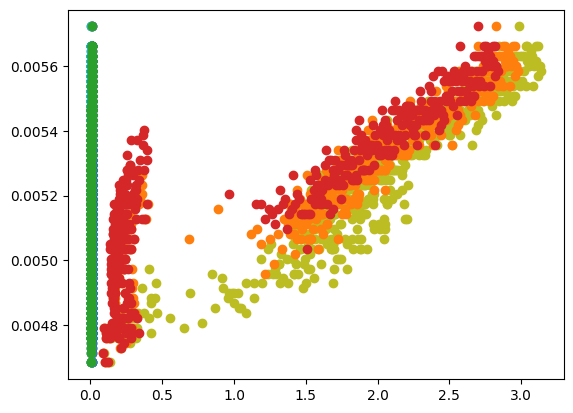

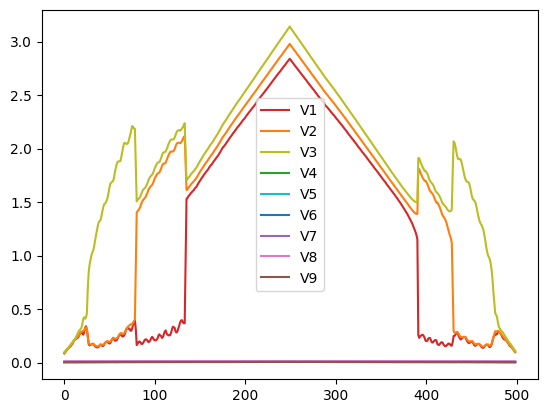

In [84]:
# time.sleep(5)
outd = V0_scan_updown(V0max=3, steps=250, sleep=0, nsamples=2)
# outd = V0_scan_updown(V0max=3, steps=200, sleep=0, nsamples=5)


for i in range(len(edgecomms)):
    plt.scatter(outd['V{}'.format(i+1)], outd.Vr, zorder = -1*i, color=colors[i])
plt.show()

for i in range(len(edgecomms)):
    plt.plot(outd['V{}'.format(i+1)], label='V{}'.format(i+1), color=colors[i])
plt.legend()

plt.show()

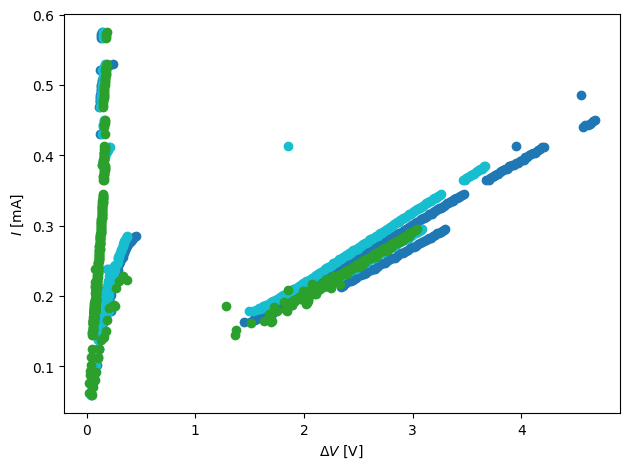

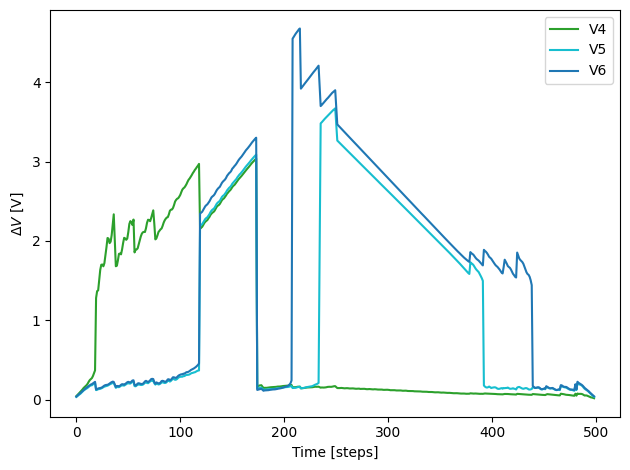

In [73]:
fig, ax = plt.subplots()
for i in range(3,6):
    ax.scatter(outd['V{}'.format(i+1)], outd.Vr/R0*1e3, zorder = -1*i, color=colors[i])
ax.set_xlabel(r'$\Delta V$ [V]')
ax.set_ylabel(r'$I$ [mA]')
fig.tight_layout()
fig.savefig('avalanche_IV.png')
plt.show()
fig, ax = plt.subplots()
for i in range(3,6):
    plt.plot(outd['V{}'.format(i+1)], label='V{}'.format(i+1), color=colors[i])
plt.legend()
ax.set_ylabel(r'$\Delta V$ [V]')
ax.set_xlabel(r'Time [steps]')
fig.tight_layout()
fig.savefig('avalanche_dV_t.png')
plt.show()

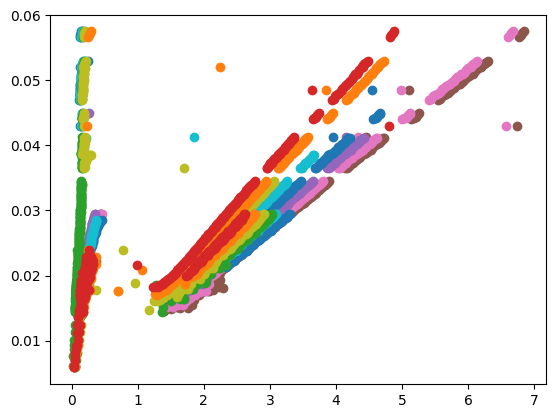

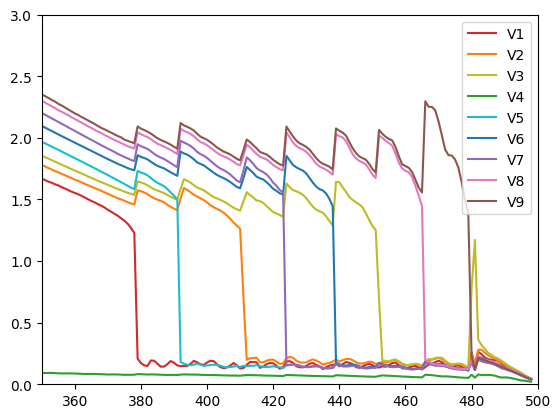

In [65]:
for i in range(len(edgecomms)):
    plt.scatter(outd['V{}'.format(i+1)], outd.Vr, zorder = -1*i, color=colors[i])
plt.show()

for i in range(len(edgecomms)):
    plt.plot(outd['V{}'.format(i+1)], label='V{}'.format(i+1), color=colors[i])
plt.legend()
plt.xlim(350, 500)
plt.ylim(0,3)

plt.show()

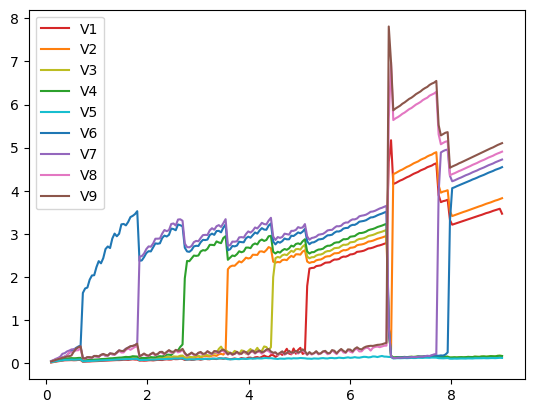

In [221]:
boutd = outd[outd.index < 200]

for i in range(len(edgecomms)):
    plt.plot(boutd.V0, boutd['V{}'.format(i+1)], label='V{}'.format(i+1), color=colors[i])
plt.legend()

27.0084228515625


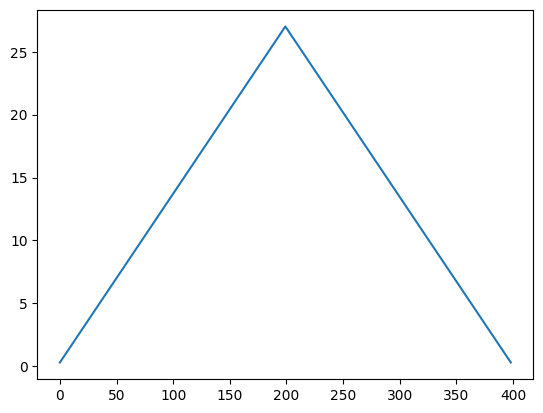

In [190]:
plt.plot(outd.V0*gain)

print(np.max(outd.V0)*gain)

In [ ]:
 plt.scatter(outd.V1, outd.Vr)

offV1 = outd[outd.V1 < 1]
onV1 = outd[outd.V1 > 1]

peak = offV1[offV1.Vr == np.max(offV1.Vr)]
valley = onV1[onV1.Vr == np.min(onV1.Vr)]

plt.scatter(peak.V1, peak.Vr)
plt.scatter(valley.V1, valley.Vr)

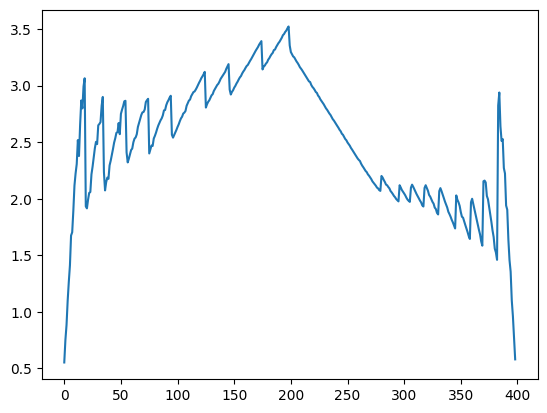

In [172]:
# plt.plot(outd.V0*gain)
plt.plot(outd.Vr*R0)

In [56]:
outd['R0'] = R0
outd['V0gain'] = gain
outd['RL1'] = 10e3
outd['RL2'] = 10.5e3
outd['RL3'] = 11e3
outd['RL4'] = 11.5e3
outd['RL5'] = 12e3
outd['RL6'] = 12.5e3
outd['RL7'] = 13e3
outd['RL8'] = 13.5e3
outd['RL9'] = 14e3
for e in edgecomms.itertuples():
    outd['Vg{}'.format(e.edge)] = e.Vgg

outd

,V1,V2,V3,V4,V5,V6,V7,V8,V9,Vr,...,RL9,Vg1,Vg2,Vg3,Vg4,Vg5,Vg6,Vg7,Vg8,Vg9
0,0.030670,0.038452,0.038757,0.046997,0.036774,0.041199,0.037384,0.043182,0.036469,0.005859,...,14000.0,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4
1,0.043182,0.049591,0.053253,0.059814,0.046234,0.053864,0.047455,0.054932,0.048065,0.007034,...,14000.0,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4
2,0.053711,0.063019,0.067596,0.074158,0.058441,0.065308,0.058594,0.066528,0.058441,0.008011,...,14000.0,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4
3,0.067596,0.078125,0.079346,0.088043,0.068359,0.075684,0.069733,0.077057,0.068817,0.009171,...,14000.0,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4
4,0.073853,0.092773,0.093384,0.102844,0.078125,0.086823,0.078278,0.086060,0.080414,0.011200,...,14000.0,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,0.101471,0.099792,0.109100,0.037231,0.083618,0.092163,0.083466,0.094757,0.086365,0.010101,...,14000.0,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4
495,0.086823,0.088654,0.093689,0.031128,0.070953,0.080261,0.072174,0.081787,0.074158,0.009369,...,14000.0,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4
496,0.068359,0.069122,0.075378,0.029449,0.059204,0.066681,0.059204,0.068207,0.061798,0.008713,...,14000.0,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4
497,0.051422,0.053406,0.061340,0.025024,0.049438,0.055542,0.050049,0.056915,0.050049,0.007645,...,14000.0,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4


In [57]:
outd.to_csv('sequences/9NDR/avalanche_1025.csv')

In [22]:
ul.release_daq_device(in_num)
ul.release_daq_device(out_num)

In [ ]:
outdict